# GPS VS ARGOS

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_true_err_cor_part, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var

In [7]:
DL =25*1e3 #meters
DT = 0.5*3600 #seconds
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'

id_co_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

In [8]:
def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes+trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# Datasets 

In [9]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global_save',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global_save',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsms.drifter_sat_year.values if 'argos' in l]

dsg, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserrg = (msup-mslow)/2

dsa, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=argos), dsms.sel(drifter_sat_year=argos), alpha=0.01)
mserra = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(146030)
<xarray.DataArray 'nb_coloc' ()>
array(91830)


______________________
# Closure efficiancy : $\langle S^2 \rangle$ and $RSE = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

In [10]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RSE_id(ds, id_):
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return (ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])).values*100

In [11]:
print('Along-track')
print('S2 = ' + f"{dsg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsg, id_co)}")
print('AVISO')
print('S2 = ' + f"{dsg['sum_'+id_aviso].values}")
print(f"RSE = {RSE_id(dsg, id_aviso)}")


print('Along-track')
print('S2 = ' + f"{dsa['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsa, id_co)}")
print('AVISO')
print('S2 = ' + f"{dsa['sum_'+id_aviso].values}")
print(f"RSE = {RSE_id(dsa, id_aviso)}")

Along-track
S2 = 1.921803634929271e-10
RSE = 22.72512250833463
AVISO
S2 = 1.7747511628038371e-10
RSE = 24.64211276572853
Along-track
S2 = 3.424028508617704e-10
RSE = 34.038856239953226
AVISO
S2 = 3.1705922091357593e-10
RSE = 35.85914568643908


Text(0, 0.5, '$\\langle S^2 \\rangle$ $[m^2/s^4]$')

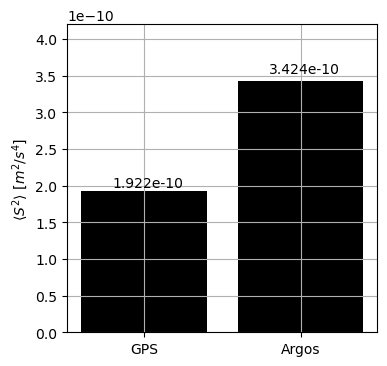

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, dsg['sum_'+id_co], color ='k',width = 0.4)
ax.bar(1, dsa['sum_'+id_co], color ='k',width = 0.4)
ax.text(0.4, dsg['sum_'+id_co]+dsg['sum_'+id_co]/30, str(np.format_float_scientific(dsg['sum_'+id_co].values,precision = 3)))
ax.text(0.9, dsa['sum_'+id_co]+dsa['sum_'+id_co]/30, str(np.format_float_scientific(dsa['sum_'+id_co].values,precision = 3)))

ax.grid()
ax.set_ylim(0,4.2e-10)
ticks = ('GPS', 'Argos')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$\langle S^2 \rangle$ $[m^2/s^4]$')

Text(0, 0.5, '$RSE$ [%]')

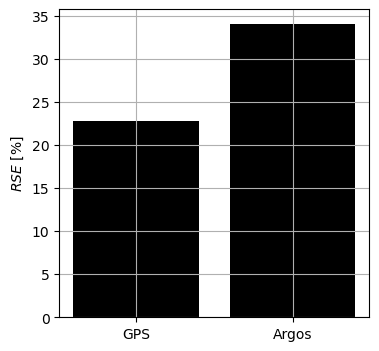

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, RSE_id(dsg, id_co), color ='k',width = 0.4)
ax.bar(1, RSE_id(dsa, id_co), color ='k',width = 0.4)

ax.grid()

ticks = ('GPS', 'Argos')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$RSE$ [%]')

_____________
# Correlation + balanced/error parts

$$ B_i  = \frac{1}{2} (A_i  - S +S_{-i}) = - \sum_{j\neq i} \langle a_i a_j \rangle = - \langle a_i s_{-i}\rangle $$
$$ E_i  = \frac{1}{2} (A_i  + S -S_{-i}) =  \langle a_i s \rangle $$

In [14]:
def global_cor(dsc):
    #global ms
    cor = (((dsc*dsc.nb_coloc).sum('drifter_sat_year'))/(dsc.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    print(dsc.nb_coloc.sum('drifter_sat_year'))
    for v in dsc.keys():
        if v != 'nb_coloc':
            cor[v].attrs=dsc[v].attrs
    
    #nb_coloc
    nb_coloc = dsc.nb_coloc.sum('drifter_sat_year')
    cor['nb_coloc']=nb_coloc
    return cor

In [15]:
import itertools
from histlib.diagnosis import global_drifter_sat, error_on_covariances
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

dsc = xr.open_dataset(os.path.join(zarr_dir+'_ok','global_save',f'corr_{int(DL//1000)}_{DT}_drogued.zarr'))[corr_var_co+['nb_coloc']]
gps = [l for l in dsc.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsc.drifter_sat_year.values if 'argos' in l]
dsgcor_co = global_drifter_sat(dsc.sel(drifter_sat_year=gps))
dsgcor_co_err = error_on_covariances(dsgcor_co, dsg , corr_key_co, alpha=0.0001)

dsacor_co = global_drifter_sat(dsc.sel(drifter_sat_year=argos))
dsacor_co_err = error_on_covariances(dsacor_co, dsa , corr_key_co, alpha=0.0001)



<xarray.DataArray 'nb_coloc' ()>
array(146030)
<xarray.DataArray 'nb_coloc' ()>
array(91830)


In [16]:
dsmsa = xr.concat([true_err_x(dsa,mserra, id_co), true_err_x(dsa,mserra, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
dsmsg = xr.concat([true_err_x(dsg,mserrg, id_co), true_err_x(dsg,mserrg, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [26]:
def synthetic_figure(ds, dsc, dic, ax, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    print(ts)
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400
    
    ## INDIVIDUAL MS ##
    ax.barh(2*a, ds['acc'], color= c0['acc'], label = 'Inertial acceleration')
    ax.barh(2*a, ds['coriolis'], left =ds['acc']+b , color= c0['coriolis'], label = 'Coriolis acceleration')
    ax.barh(2*a, ds['ggrad'], left =ds['acc']+ds['coriolis']+2*b , color= c0['ggrad'], label = 'Pressure gradient term')
    ax.barh(2*a, ds['wind'], left =ds['acc']+ds['coriolis']+ds['ggrad']+3*b, color= c0['wind'], label = 'Wind term')
    

    ax.text(ts/2, 2*a+0.5, r'Individual MS $A_i$', ha='center') 
    #percentage + MS
    key = ['acc', 'coriolis', 'ggrad', 'wind']
    for i in range(len(key)) :
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center',bbox=bbox )
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a-0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
    
    #accolade
    c = 1e-12
    id1 =0
    id2 = ts + 3*b
    bx = [id1, id1, id2, id2]
    by = [3.70, 3.75, 3.75, 3.70]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(ts, 3.8, r'$\Sigma$', fontsize=15, ha='center')
    
    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    ax.barh(1*a, ds['true_acc'], color= c0['acc'])
    ax.barh(1*a, ds['err_acc'], left = ds['true_acc'], color= 'lightgrey', label='Errors')
    ax.barh(1*a, ds['true_coriolis'], left =ds['true_acc']+ds['err_acc']+b, color= c0['coriolis'])
    ax.barh(1*a, ds['err_coriolis'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis'], color= 'lightgrey')
    ax.barh(1*a, ds['true_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+b, color= c0['ggrad'])
    if ds['err_ggrad']>0 : 
        ax.barh(1*a, ds['err_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad'], color= 'lightgrey')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+ds['true_wind'], color= 'lightgrey')
    else : 
        print('ok')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+2*b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['true_wind']+2*b, color= 'lightgrey')
    
    ax.text(ts/2, 1*a+0.5, r'Balanced physical and errors parts MS $B_i$ and $E_i$', ha='center') 
    #percentage + MS
    key = ['true_acc','err_acc', 'true_coriolis','err_coriolis', 'true_ggrad','err_ggrad', 'true_wind', 'err_wind']
    for i in range(len(key)) :
        d=0
        dx=0
        if i==len(key)-1 : 
            d=-0.1*a 
            dx = 3e-11
        if i==len(key)-2 : d=0.1*a 
        if 'aviso' in dic['ggrad'] and i==len(key)-3 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2, a+d, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dx, a+d -0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b)

    tts = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b+ds['S']
    print(tts)
    sum_pairs = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    key = [vn(dic, 'coriolis', 'ggrad'),vn(dic, 'acc', 'coriolis'), vn(dic, 'acc', 'ggrad'), vn(dic, 'coriolis', 'wind')]
    for i in range(len(key)) :
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0, f'{int(np.rint((dsc[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0
        if 'aviso' in dic['ggrad'] and key[i]== vn(dic, 'acc', 'ggrad') : d = -0.1*a
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0-0.55+d, f'{np.format_float_scientific(dsc[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))} %', ha='center', bbox=bbox)
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    ax.set_xlim(-1e-11, xlim+1e-11)
    ax.set_ylim(-1, 4.1)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,-1),xytext=(0,-1),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

<xarray.DataArray ()>
array(1.00591761e-09)
Coordinates:
    id_comb  <U70 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...
<xarray.DataArray ()>
array(1.02899846e-09)
Coordinates:
    id_comb  <U70 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...


Text(0.5, 0.98, 'Argos before 2.5cpd low-pass')

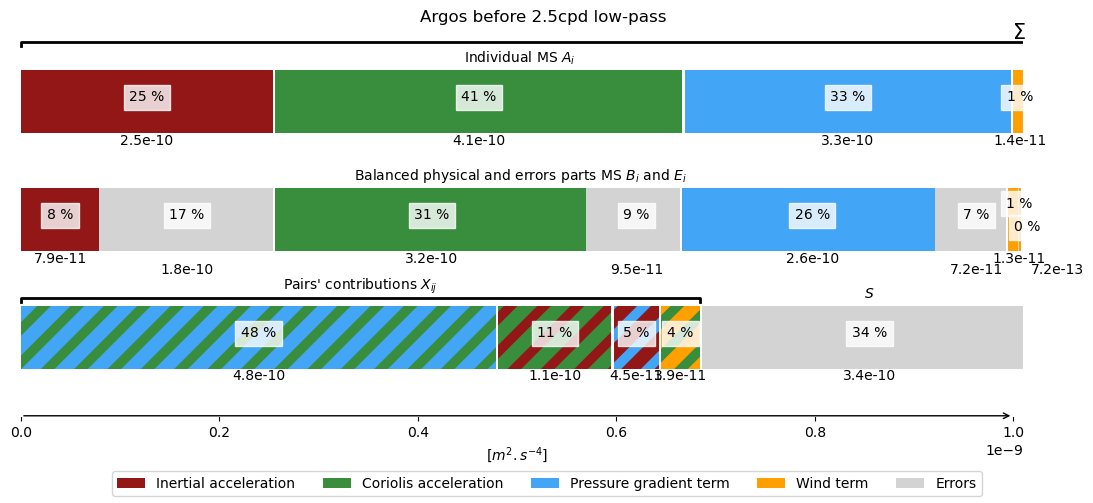

In [27]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False, )

synthetic_figure(dsmsa.sel(id_comb=id_co), -2*dsacor_co, id_co_dic, ax, xlim=1e-9) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('Argos before 2.5cpd low-pass')
#fig.savefig('images/synth_alg.png',bbox_inches='tight',   dpi=300)

<xarray.DataArray ()>
array(8.45673608e-10)
Coordinates:
    id_comb  <U70 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...
<xarray.DataArray ()>
array(8.69766027e-10)
Coordinates:
    id_comb  <U70 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...


Text(0.5, 0.98, 'GPS before 2.5cpd low-pass')

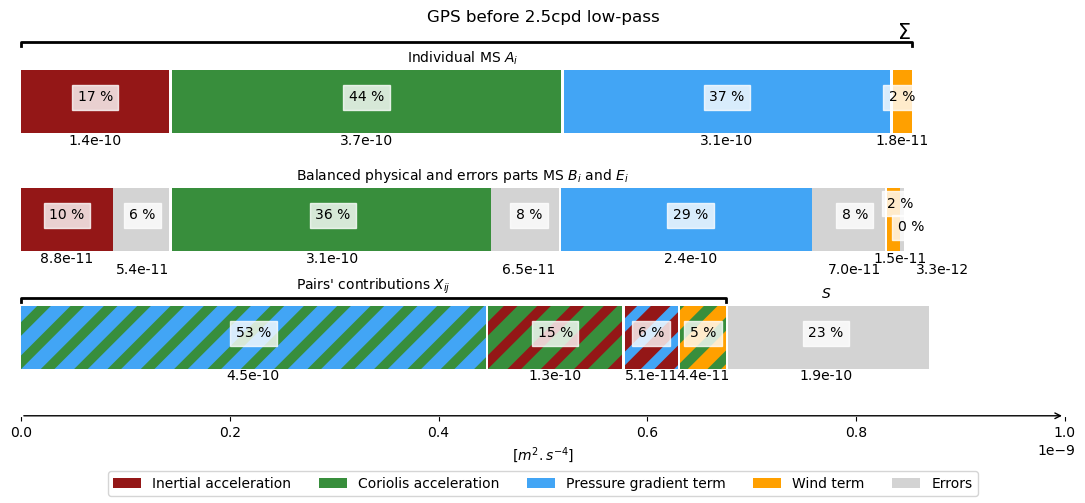

In [28]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False, )

synthetic_figure(dsmsg.sel(id_comb=id_co), -2*dsgcor_co, id_co_dic, ax, xlim=1e-9) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('GPS before 2.5cpd low-pass')
#fig.savefig('images/synth_alg.png',bbox_inches='tight',   dpi=300)